In [1]:
# WRITTEN BY ALAN LI
# NASA AMES LABORATORY FOR ADVANCED SENSING (LAS)
# Last edited: Aug 18, 2017
# Modified, Sep 15, 2017, Michal Segal Rozenhaimer, NASA, Ames

import sys
import random
import numpy as np
import cv2
import tensorflow as tf
import glob
from matplotlib import pyplot as plt
from collections import Counter
import pandas as pd

# Config the matplotlib backend as plotting in line in IPython
%matplotlib notebook

In [2]:
# Image paths
transect1 = '../Images/Transect 1 Hi-Res.tiff'
transect1_truth = '../Images/Transect 1 Truth data.tif'

# Load images
img1 = cv2.imread(transect1,cv2.IMREAD_UNCHANGED)
img1_truth = cv2.imread(transect1_truth,cv2.IMREAD_UNCHANGED)
                
# Remap truth data
if transect1_truth == '../Images/Transect 1 Truth data.tif':
    img1_truth[img1_truth == 16] = 0  # Sand
    img1_truth[img1_truth == 160] = 1 # Branching
    img1_truth[img1_truth == 198] = 2 # Mounding
    img1_truth[img1_truth == 38] = 3 # Rock

# NOTE: N_images = number of images in a set (e.g. training set, validation set, etc...)
#       N_labels = # of classified pixels associated with an image (i.e. Might want to classify 4 central pixels of a NxN image)
#       num_labels = # of labels (e.g. sand, rock, branching, mounding)
#### Randomize set of data
'''Input:
    dataset: set of images, N_images x (nrow*ncol) x n_channels
    labels: set of labels, N_images x N_labels x num_labels 
Output:
    shuffled_dataset: set of randomized images, N_images x (nrow*ncol) x (n_channels-n_toremove)
    shuffled_labels: set of randomized labels, N_images x N_labels x num_labels
'''
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation,:,:]
    return shuffled_dataset, shuffled_labels    
    
#### Reformat image into input vector style and randomize
'''Input:
    imgset: set of images, N_images x nrow x ncol x n_channels
    toremove: index of channel dimension to remove
    labels: set of labels, N_images x N_labels (N_labels > 1 when we want to classify a number of pixels per image) 
    num_labels: number of possible labels for the entire dataset (4 for morphology, 2 for coral cover)
    randomize: boolean, to randomize dataset or not
Output:
    dataset: set of vectorized images, N_images x nrow x ncol x (n_channels-n_toremove)
    labels: set of vectorized labels in the form of logits, N_images x N_labels x num_labels
'''
def reformat(imgset, toremove, labels, num_labels, random_flag):    
    imgsetcut = imgset
    if toremove is not None:
        imgsetcut = np.delete(imgset,toremove,-1) # Remove specific last dimension of array
    labels = np.asarray([[(np.arange(num_labels) == labels[i,j]).astype(np.float32) for j in range(labels.shape[1])] for i in range(imgsetcut.shape[0])])
    if random_flag:
        dataset, labels = randomize(imgsetcut, labels)
    else:
        dataset = imgsetcut
    return dataset, labels

#### Normalize Image
'''Input:
    dataset: set of vectorized images, N_images x nrow x ncol x n_channels
    depth: pixel depth, float
Output:
    dataset_norm: set of vectorized normalized images, N_images x nrow x ncol x n_channels'''
def rescale(dataset, depth):
    dataset_norm = (dataset.astype(np.float32) - depth/2)/(depth/2)
    return dataset_norm

In [3]:
# Create Training, Validation and Test sets (could probably write a function for this later instead...)

num_labels = 4
image_size = 25 # side length of one sample image
N_train = 20000 # number of training samples per class
N_valid = 2500 # number of validation samples per class
N_test = 2500 # number of test samples per class
crop_len = int(np.floor(image_size/2))
img1_truth_crop = img1_truth[crop_len:img1_truth.shape[0]-crop_len, crop_len:img1_truth.shape[1]-crop_len]

# Randomly select points
train_datasets = []
train_labels = []
valid_datasets = []
valid_labels =[]
test_datasets = []
test_labels = []

for k in range(num_labels):
    [i,j] = np.where(img1_truth_crop == k)
    # Training set
    idx = np.asarray(random.sample(range(len(i)), N_train)).astype(int)
    train_datasets.append([img1[i[idx[nn]]:i[idx[nn]]+image_size, j[idx[nn]]:j[idx[nn]]+image_size, :] for nn in range(len(idx))])
    train_labels.append([img1_truth_crop[i[idx[nn]], j[idx[nn]]] for nn in range(len(idx))])
    # Validation set
    idx = np.asarray(random.sample(range(len(i)), N_valid)).astype(int)
    valid_datasets.append([img1[i[idx[nn]]:i[idx[nn]]+image_size, j[idx[nn]]:j[idx[nn]]+image_size, :] for nn in range(len(idx))])
    valid_labels.append([img1_truth_crop[i[idx[nn]], j[idx[nn]]] for nn in range(len(idx))])
    # Test set
    idx = np.asarray(random.sample(range(len(i)), N_test)).astype(int)
    test_datasets.append([img1[i[idx[nn]]:i[idx[nn]]+image_size, j[idx[nn]]:j[idx[nn]]+image_size, :] for nn in range(len(idx))])
    test_labels.append([img1_truth_crop[i[idx[nn]], j[idx[nn]]] for nn in range(len(idx))])
    
# Some array handling and reshaping
train_datasets = np.asarray(train_datasets) # train_datasets is in the format of num_labels x N_train x nrows x ncols x n_channels
train_labels = np.asarray(train_labels) # train_labels is in the format of num_labels x N_train
valid_datasets = np.asarray(valid_datasets)
valid_labels = np.asarray(valid_labels) 
test_datasets = np.asarray(test_datasets) 
test_labels = np.asarray(test_labels) 

train_datasets = train_datasets.reshape(num_labels*N_train, image_size, image_size, img1.shape[-1]) # flatten first 2 dimensions of train_datasets
train_labels = train_labels.reshape(num_labels*N_train,1) # flatten into vector
valid_datasets = valid_datasets.reshape(num_labels*N_valid, image_size, image_size, img1.shape[-1]) 
valid_labels = valid_labels.reshape(num_labels*N_valid,1) 
test_datasets = test_datasets.reshape(num_labels*N_test, image_size, image_size, img1.shape[-1]) 
test_labels = test_labels.reshape(num_labels*N_test,1) 

<IPython.core.display.Javascript object>


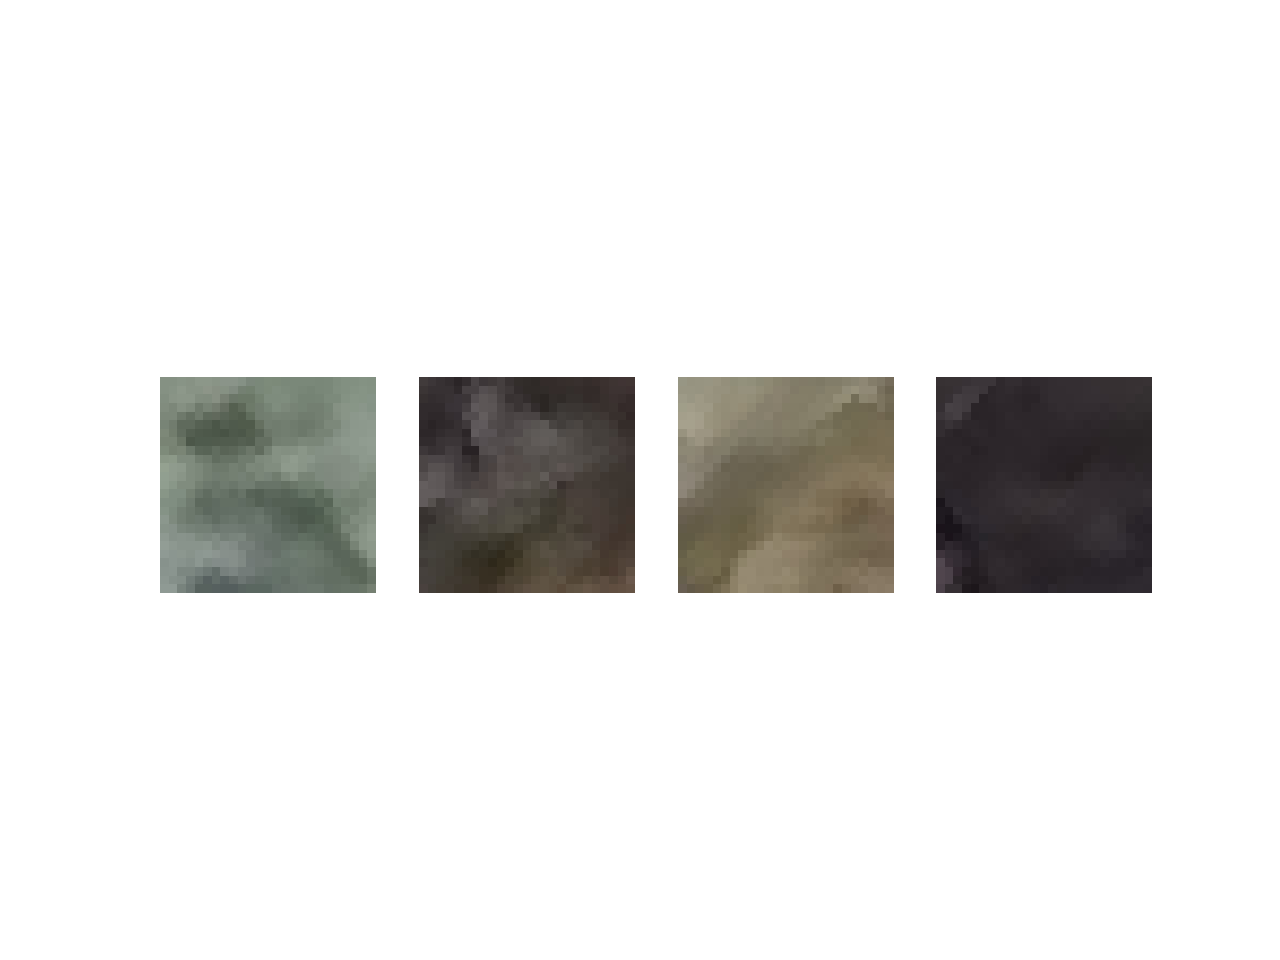

In [4]:
# Plot sample images of different classes
plt.figure(1)
for i in range(num_labels):
    plt.axis("off")
    plt.subplot(1, num_labels, i+1)
    plt.imshow(cv2.cvtColor(train_datasets[i*N_train,:,:,0:3], cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [5]:
depth = 255.0

# More array operations, randomize sets, and normalize from -1 to 1
train_dataset, train_labelset = reformat(train_datasets, 3, train_labels, num_labels, True) # Reformat shape into batch arrays
valid_dataset, valid_labelset = reformat(valid_datasets, 3, valid_labels, num_labels, True)
test_dataset, test_labelset = reformat(test_datasets, 3, test_labels, num_labels, True)
print("Training dataset dimensions: ", train_dataset.shape, "Training labels dimensions: ", train_labelset.shape)
print("Validation dataset dimensions: ", valid_dataset.shape, "Validation labels dimensions: ", valid_labelset.shape)
print("Test dataset dimensions: ", test_dataset.shape, "Test labels dimensions: ", test_labelset.shape)

train_dataset = rescale(train_dataset,depth)
valid_dataset = rescale(valid_dataset,depth)
test_dataset = rescale(test_dataset,depth)

num_channels = train_dataset.shape[-1]
N_labels = train_labelset.shape[1]
print("Num_channels:", num_channels, "N_labels:", N_labels)

Training dataset dimensions:  (80000, 25, 25, 3) Training labels dimensions:  (80000, 1, 4)
Validation dataset dimensions:  (10000, 25, 25, 3) Validation labels dimensions:  (10000, 1, 4)
Test dataset dimensions:  (10000, 25, 25, 3) Test labels dimensions:  (10000, 1, 4)
Num_channels: 3 N_labels: 1


In [6]:
# Tensorflow Implementation
batch_size = 32
patch1_size = 5
stride1 = 1
patch2_size = 5
stride2 = 1
depth1 = 64
depth2 = 128
depth3 = 256
depth4 = 64

graph = tf.Graph()
with graph.as_default():
    # Datasets
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size,N_labels,num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    tf_whole_dataset = tf.placeholder(tf.float32, shape=(img1.shape[1]-2*crop_len, image_size, image_size, num_channels))
        
    # Size of arrays
    layer1size = (image_size-patch1_size)//stride1 + 1
    layer2size = (layer1size-patch2_size)//stride2 + 1
    
    # Variables
    C1_weights = tf.Variable(tf.truncated_normal([patch1_size, patch1_size, num_channels, depth1], stddev=0.1))
    C1_biases = tf.Variable(tf.zeros([depth1]))
    C2_weights = tf.Variable(tf.truncated_normal([patch2_size, patch2_size, depth1, depth2], stddev=0.1))
    C2_biases = tf.Variable(tf.constant(1.0, shape=[depth2]))
    F3_weights = tf.Variable(tf.truncated_normal([layer2size*layer2size*depth2, depth3], stddev=0.1))
    F3_biases = tf.Variable(tf.constant(1.0, shape=[depth3]))
    F4_weights = tf.Variable(tf.truncated_normal([depth3, depth4], stddev=0.1))
    F4_biases = tf.Variable(tf.constant(1.0, shape=[depth4]))
    F5_weights = tf.Variable(tf.truncated_normal([N_labels, depth4, num_labels], stddev=0.1))
    F5_biases = tf.Variable(tf.constant(1.0, shape=[N_labels,1,num_labels]))
    global_step = tf.Variable(0, trainable=False)
    
    # Model
    def model_CNN(data):
        C1 = tf.nn.conv2d(data, C1_weights, [1,stride1,stride1,1], padding = 'VALID') + C1_biases
        C1 = tf.nn.relu(C1)
#         C1 = tf.nn.max_pool(C1, [1, stride1, stride1, 1], [1, stride1, stride1, 1], padding = 'SAME')
        
        C2 = tf.nn.conv2d(C1, C2_weights, [1,stride2,stride2,1], padding = 'VALID') + C2_biases
        C2 = tf.nn.relu(C2)
        
        shape = C2.get_shape().as_list()
        C2_reshape = tf.reshape(C2, [shape[0], shape[1]*shape[2]*shape[3]])
        F3 = tf.matmul(C2_reshape, F3_weights) + F3_biases
        F3 = tf.nn.relu(F3)
        
        F4 = tf.matmul(F3, F4_weights) + F4_biases
        F4 = tf.nn.relu(F4)
        F4_extend = tf.expand_dims(F4,0)
        F4_tile = tf.tile(F4_extend, [N_labels,1,1])
        
        F5 = tf.matmul(F4_tile,F5_weights) + F5_biases
        F5_reshape = tf.reshape(F5, [shape[0]*N_labels,num_labels]) # Reshape into 2d matrix
        return F5_reshape

    # Training computation
    labelshape = tf_train_labels.get_shape().as_list()
    tf_train_labelreshape = tf.reshape(tf_train_labels, [labelshape[0]*labelshape[1], labelshape[2]])
    logits = model_CNN(tf_train_dataset)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labelreshape, logits=logits))
    
    # Optimizer
    learning_rate = tf.train.exponential_decay(0.01, global_step, 10000, 0.95)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    # Predictions for training, validation, and test data
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model_CNN(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model_CNN(tf_test_dataset))
    whole_prediction = tf.nn.softmax(model_CNN(tf_whole_dataset))
    
    saver = tf.train.Saver()

In [7]:
# More definitions, mostly for whole data manipulation

def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

def classifyback(predictions):
    return np.argmax(predictions,1)

def whole_data(counter):
    whole_datasets = []
    whole_labels = []
    num_wholepixels = img1.shape[1]-2*crop_len
    for j in range(crop_len, img1.shape[1]-crop_len):
        whole_datasets.append(img1[counter-crop_len:counter+crop_len+1, j-crop_len:j+crop_len+1,:])
        whole_labels.append(img1_truth[counter,j])
    whole_datasets = np.asarray(whole_datasets) 
    whole_labels = np.asarray(whole_labels).reshape((len(whole_labels),1))
    whole_dataset, whole_labelset = reformat(whole_datasets, 3, whole_labels, num_labels, False)
    whole_dataset = rescale(whole_dataset,depth)
    return whole_dataset, whole_labelset

In [8]:
# Run Neural Network
num_steps = 20001
offstart = 5000
whole_len = 8574
counter = crop_len

whole_dataset, whole_labelset = whole_data(crop_len)
final_predict = np.zeros((whole_len,whole_labelset.shape[0]), dtype=np.uint8)

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labelset = train_labelset[offset:(offset + batch_size), :, :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labelset, tf_whole_dataset : whole_dataset}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict = feed_dict)
        if (step % 1000 == 0):
            print('Minibatch loss at step %d: %f' % (step,l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, np.reshape(batch_labelset, [batch_size*N_labels,num_labels])))
            print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), np.reshape(valid_labelset, [N_valid*num_labels*N_labels, num_labels])))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), np.reshape(test_labelset, [N_test*num_labels*N_labels, num_labels])))
    saver.save(session, 'My_Test_Model')
    
    # Look at entire dataset line by line?
    for counter in range(crop_len+offstart ,crop_len+offstart+whole_len):
        if ((counter-crop_len-offstart) % 100 == 0):
            print('Now on step %d ' %(counter-crop_len-offstart))
        whole_dataset, whole_labelset = whole_data(counter)
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labelset, tf_whole_dataset : whole_dataset}
        whole_predict = session.run([whole_prediction], feed_dict = feed_dict)
        final_predict[counter-crop_len-offstart,:] = classifyback(whole_predict[0]).astype(np.uint8)

Initialized
Minibatch loss at step 0: 11.758356
Minibatch accuracy: 18.8%
Validation accuracy: 25.0%
Minibatch loss at step 1000: 0.307454
Minibatch accuracy: 93.8%
Validation accuracy: 86.5%
Minibatch loss at step 2000: 0.168910
Minibatch accuracy: 96.9%
Validation accuracy: 84.1%
Minibatch loss at step 3000: 0.279041
Minibatch accuracy: 87.5%
Validation accuracy: 89.8%
Minibatch loss at step 4000: 0.381934
Minibatch accuracy: 81.2%
Validation accuracy: 90.3%
Minibatch loss at step 5000: 0.491602
Minibatch accuracy: 81.2%
Validation accuracy: 89.2%
Minibatch loss at step 6000: 0.198972
Minibatch accuracy: 93.8%
Validation accuracy: 89.7%
Minibatch loss at step 7000: 0.187619
Minibatch accuracy: 93.8%
Validation accuracy: 91.5%
Minibatch loss at step 8000: 0.160518
Minibatch accuracy: 90.6%
Validation accuracy: 90.6%
Minibatch loss at step 9000: 0.221022
Minibatch accuracy: 93.8%
Validation accuracy: 92.1%
Minibatch loss at step 10000: 0.541772
Minibatch accuracy: 78.1%
Validation accu

Final Accuracy 95.7%


<IPython.core.display.Javascript object>


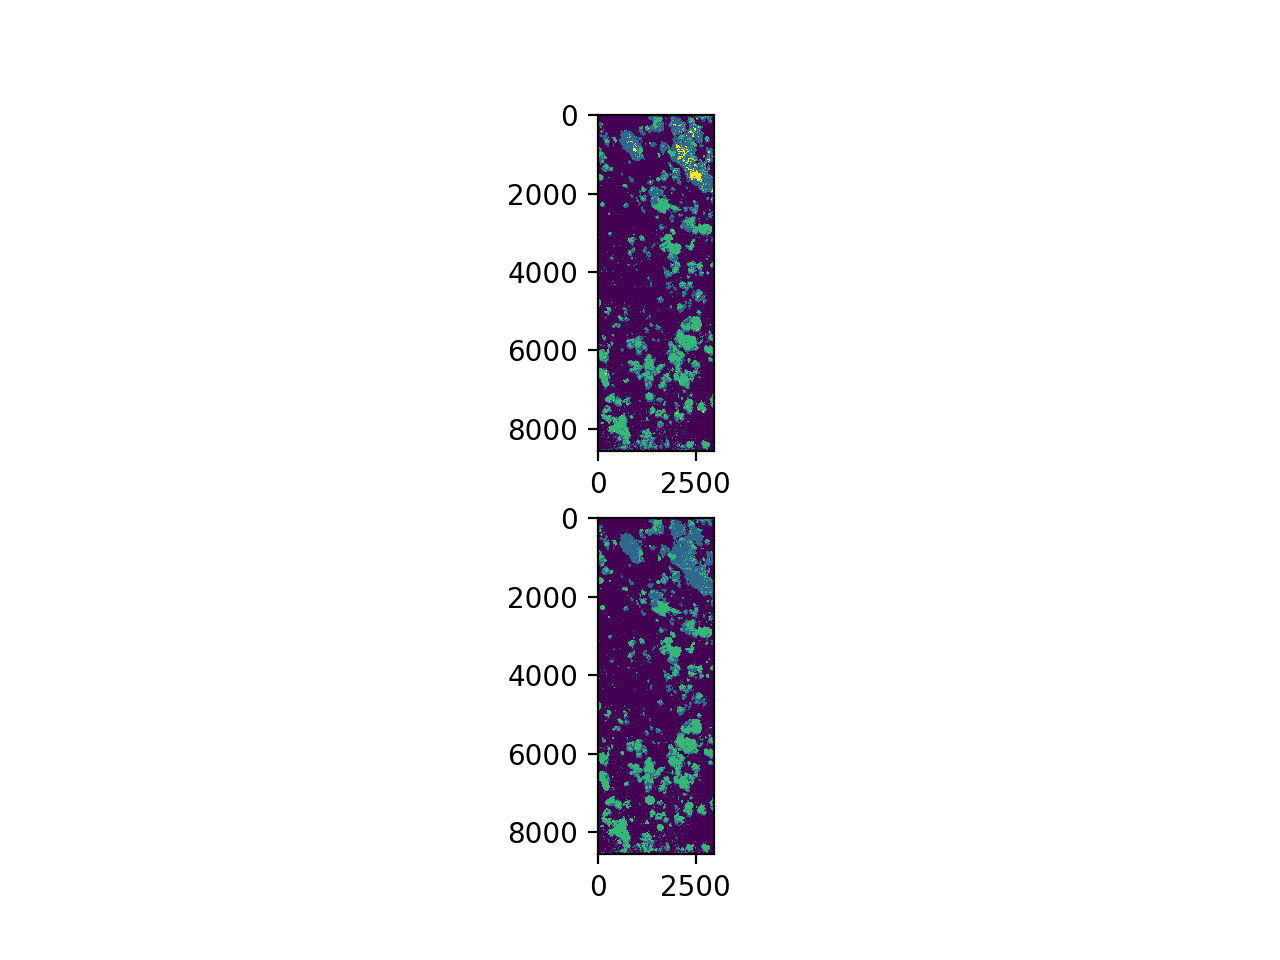

In [12]:
def accuracy2(predictions, labels):
    return (100.0 * np.sum(predictions == np.argmax(labels, 1)) / predictions.shape[0])

final_predict_uint8 = final_predict.astype(np.uint8)

# Look at entire dataset line by line... should use an easier method to do this
# temp_sum = 0
# for counter in range(crop_len+offstart,crop_len+offstart+whole_len):
#     whole_dataset, whole_labelset = whole_data(counter)
#     temp_sum += accuracy2(final_predict_uint8[counter-offstart-crop_len], np.reshape(whole_labelset, [whole_labelset.shape[0]*N_labels, num_labels]))
# temp_sum = temp_sum/whole_len

accuracy = 100*(final_predict_uint8 == img1_truth[crop_len+offstart:crop_len+offstart+whole_len, crop_len:img1_truth.shape[1]-crop_len]).sum()/(final_predict_uint8.size)
print('Final Accuracy %.1f%%' % (accuracy))
    
# final_predict = np.asarray(final_predict, dtype=np.int)
plt.figure(2)
plt.subplot(2,1,1)
plt.imshow(final_predict)
# plt.axis('off')
plt.subplot(2,1,2)
plt.imshow(img1_truth[crop_len+offstart:crop_len+offstart+whole_len,crop_len:img1_truth.shape[1]-crop_len])
# plt.axis('off')
plt.show()

Final Accuracy 94.4%


<IPython.core.display.Javascript object>


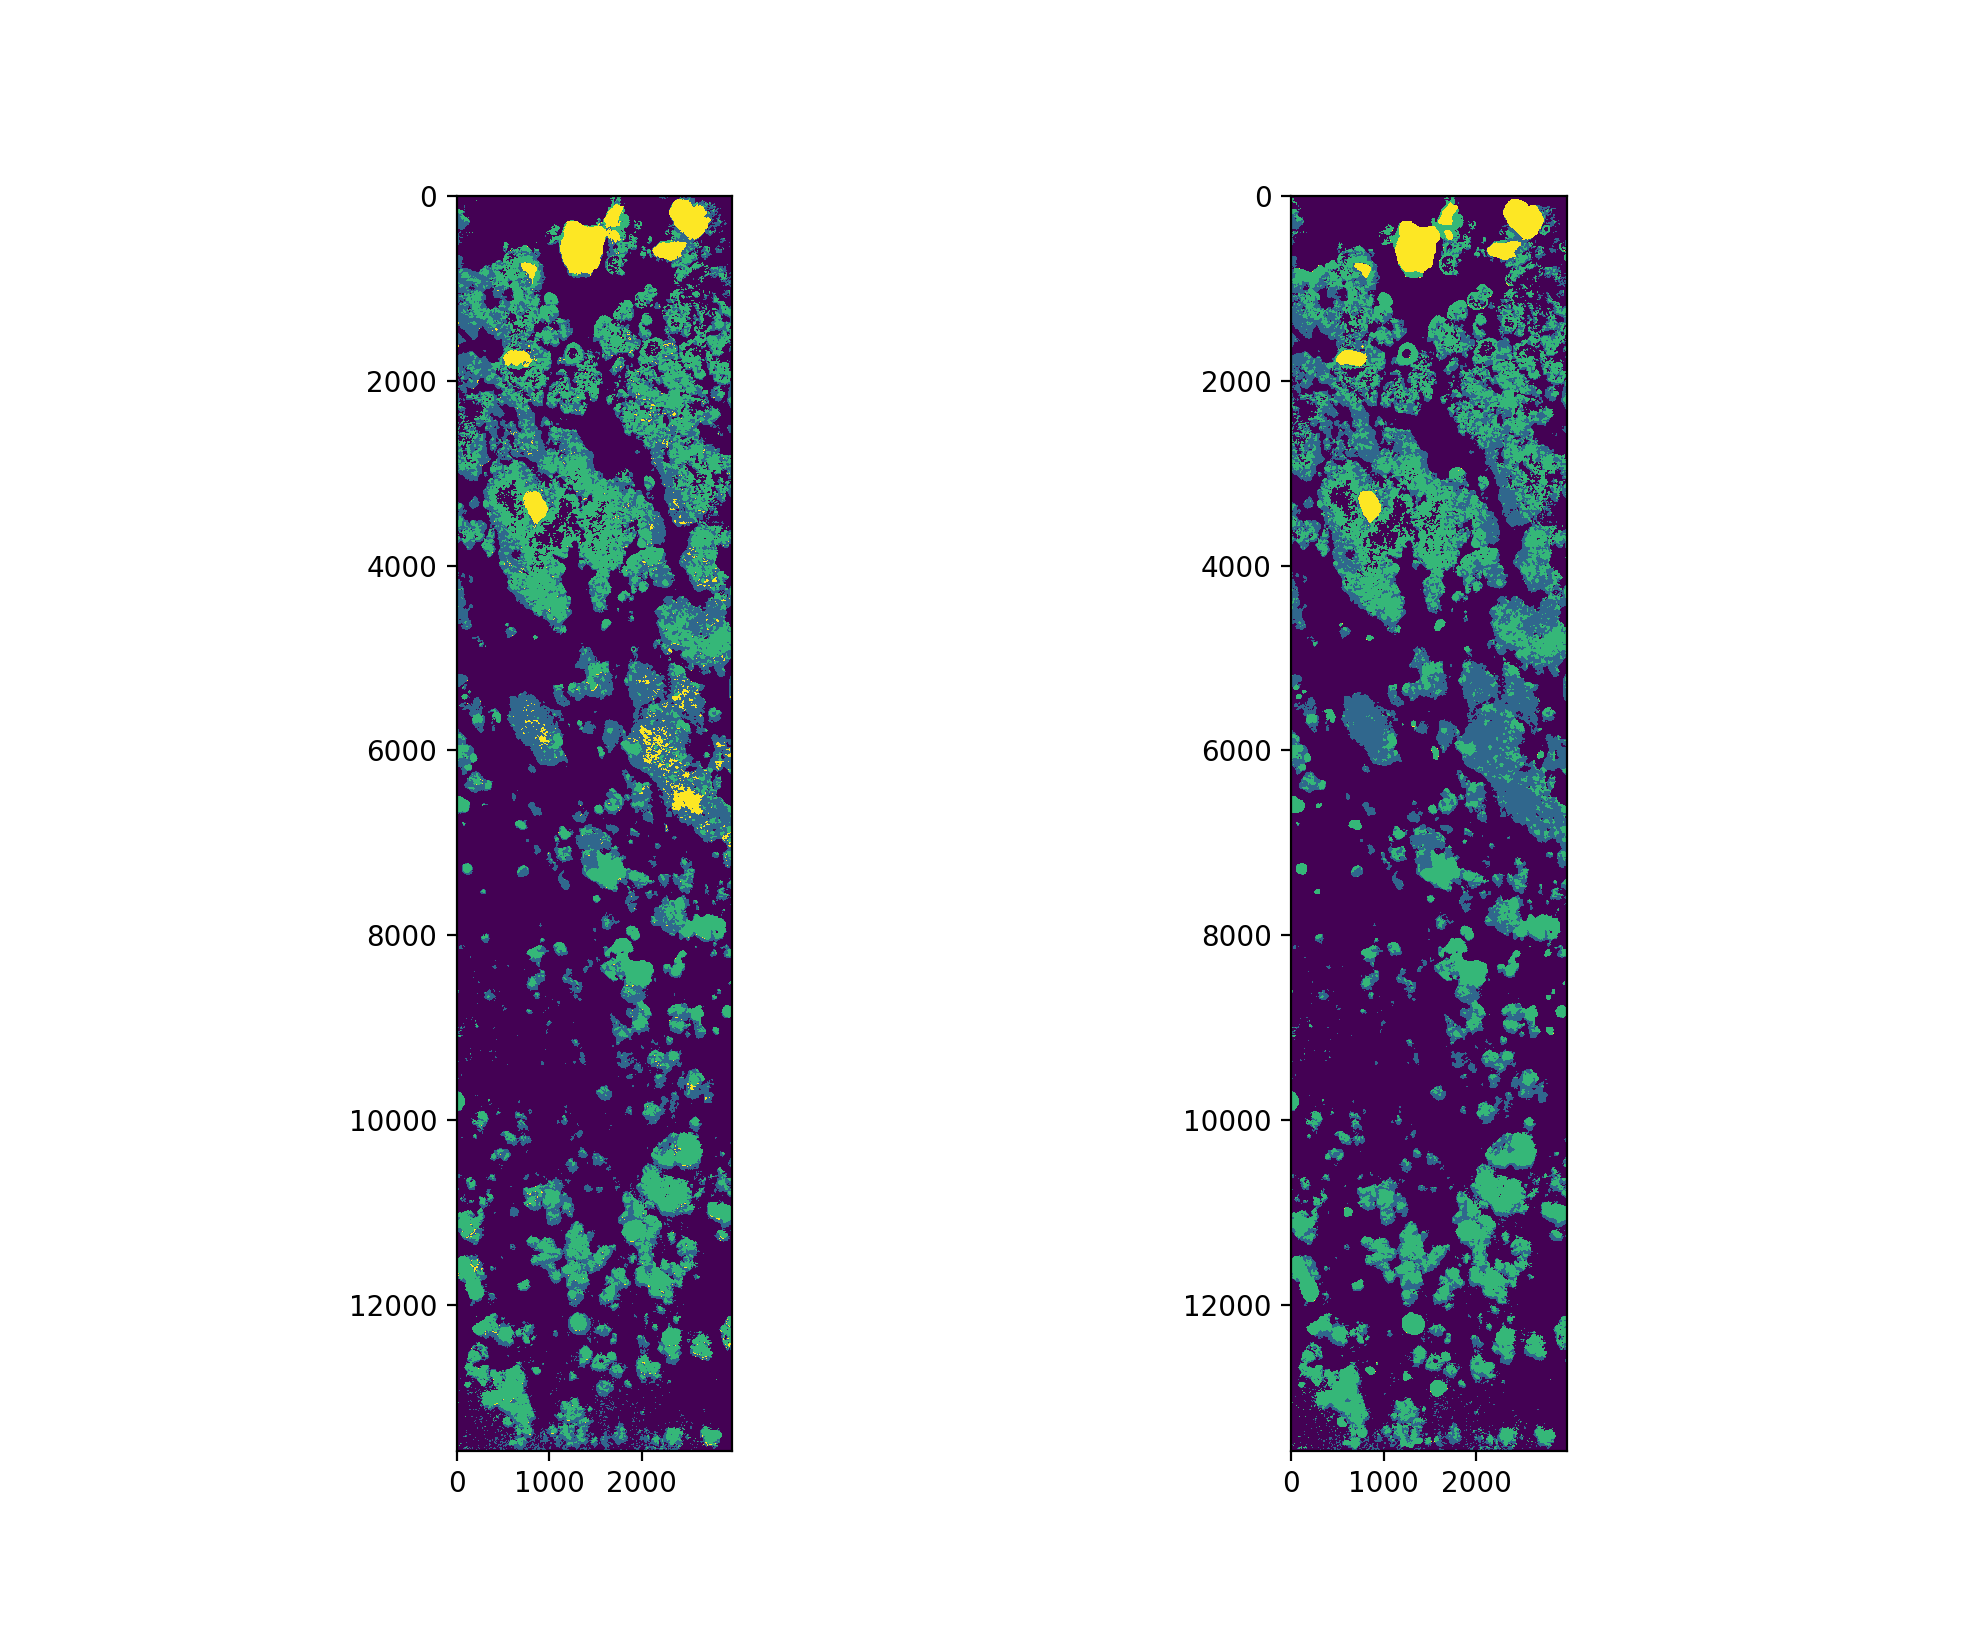

In [14]:
# ONLY RUN THIS IF YOU HAVE A COLLECTION OF .OUT FILES
# Concatenate and combine output files (there may be some overlap, and it will overwrite early files with later files)

filenames = glob.glob('*.out')
startidx = [0]*len(filenames)
for i in range(len(filenames)):
    temp = filenames[i].split("_")[1]
    startidx[i] = int(temp.split(".")[0])
    
startidx = np.asarray(startidx)
truthstore = np.zeros((img1_truth.shape[0]-2*crop_len, img1_truth.shape[1]-2*crop_len), dtype=np.uint8)
finallength = 0

for i in range(len(startidx)):
    data = np.asarray(pd.read_csv(filenames[i], sep=',', header = None))
    numlength = data.shape[0]
    truthstore[startidx[i]:startidx[i]+numlength,:] = data
    if startidx[i]+numlength > finallength:
        finallength = startidx[i]+numlength

truthstore = np.delete(truthstore, np.arange(finallength,truthstore.shape[0]), 0)
accuracy = 100*(truthstore == img1_truth[crop_len:crop_len+finallength,crop_len:img1_truth.shape[1]-crop_len]).sum()/(truthstore.size)
print('Final Accuracy %.1f%%' % accuracy)

plt.figure(3)
plt.subplot(1,2,1)
plt.imshow(truthstore)
# plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(img1_truth[crop_len:crop_len+finallength,crop_len:img1_truth.shape[1]-crop_len])
# plt.axis('off')
plt.show()

In [9]:
np.savetxt('test3.out', final_predict, delimiter=',')
# print(offstart)
# print(img1_truth.shape)
# a = np.array([[1,2],[3,4]])
# b = np.array([[1,3],[2,4]])
# c = (a==b).sum()
# print(c)
# print(a.size)